In [2]:
from pathlib import Path
from fastai.vision.all import *
import timm  # Required for loading models from timm library
import matplotlib.pyplot as plt


In [3]:
pip install timm

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Define dataset path
path = Path('C:/Users/Hanish Rajavel/Desktop/MAD/PlantDiseasesDataset')
path.ls()

# List of plant types
plant_list = ['Apple', 'Bell pepper', 'Cherry', 'Citrus', 'Corn', 'Grape', 'Peach', 'Potato', 'Strawberry', 'Tomato']
plant = 'Apple'  # Example plant class

# Define model path
model_path = Path(path/plant)


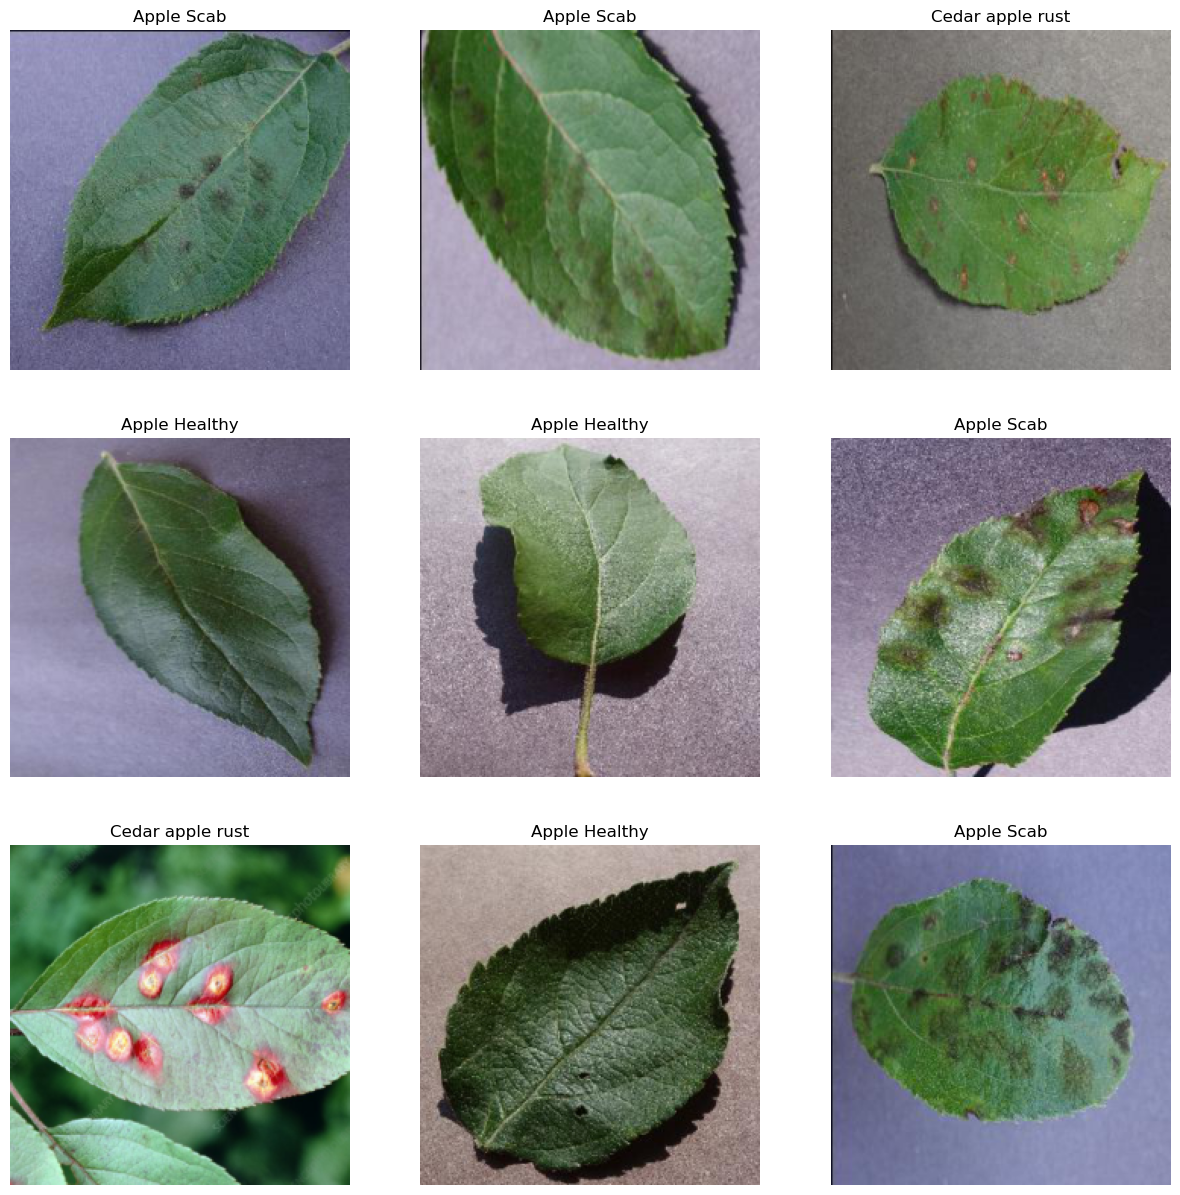

In [5]:
# Data normalization and augmentations
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

# Data loaders (train/validation split)
dls = ImageDataLoaders.from_folder(
    path/plant, train='train', valid_pct=0.2, seed=1000, item_tfms=Resize(224),
    batch_tfms=batch_tfms, bs=32
)

# Show a batch of images
dls.show_batch(figsize=(15, 15))


In [6]:
# Metrics
f1 = F1Score(average='weighted')
mcc = MatthewsCorrCoef()

# Load SE-Net model using timm
se_net_model = timm.create_model('senet154', pretrained=True, num_classes=dls.c)


In [1]:
# Create learner using SE-Net model
learn = Learner(
    dls, se_net_model, loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy, f1, mcc],
    cbs=[
        SaveModelCallback(monitor='accuracy'), 
        EarlyStoppingCallback(monitor='accuracy', patience=2),
        ShowGraphCallback()  # Automatically shows training and validation loss/accuracy graphs
    ], 
    model_dir=model_path/'models'
)  # Use mixed precision for faster training

# Train the model with one-cycle policy
learn.fit_one_cycle(20)


NameError: name 'Learner' is not defined

In [ ]:
# Fine-tune the model
learn.fine_tune(5)


In [ ]:
# Convert model back to full precision (fp32) for inference
learn = learn.to_fp32()

# Save the trained model
learn.save(model_path/f'models/{plant}')

# Load the trained model for testing/inference
learn = Learner(dls, se_net_model).load(model_path/f'models/{plant}')


In [ ]:
# Show model summary
learn.summary()

# Show results on validation set
learn.show_results(max_n=16)


In [ ]:
# Interpret the model (Confusion matrix, top losses, etc.)
interp = ClassificationInterpretation.from_learner(learn)

# Plot confusion matrix
interp.plot_confusion_matrix(figsize=(12, 12))

# Plot top losses
interp.plot_top_losses(9, figsize=(10,10))


In [ ]:
# Custom plotting for training and validation loss/accuracy
def plot_metrics():
    # Access recorded metrics from training logs
    metrics = learn.recorder
    metrics.plot_loss()  # Plot training loss
    metrics.plot_metrics()  # Plot custom metrics (accuracy, f1, etc.)

    # Extract training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot training and validation loss
    axs[0].plot(metrics.values, label='Loss')
    axs[0].set_title('Training/Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')

    # Plot accuracy/f1 score
    axs[1].plot([m[1] for m in metrics.values], label='Accuracy')
    axs[1].set_title('Training/Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')

    plt.show()

# Call custom plotting function to display metrics graphs
plot_metrics()


In [ ]:
# Export the model for future use
learn.export(f'{plant}.pkl')
